# Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad, simpson
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline, griddata, interp1d
from scipy.stats import norm, lognorm, gaussian_kde

from google.colab import drive
import cvxpy as cp
import random

# Functions

$$C(K,T) = BS(S, K, \hat{\sigma}(K), r, \tau);$$


In [ ]:
def bs_price(S, K, T, r, sigma, option_type='C'):
    """Black-Scholes option pricing formula."""
    if T <= 0 or sigma <= 0:
        return max(0.0, S - K) if option_type == 'C' else max(0.0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'C':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:  # Put
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
def implied_volatility(market_price, S, K, T, r, option_type='C'):
    """Solve for implied volatility using Brent's method."""
    def objective(sigma):
        return bs_price(S, K, T, r, sigma, option_type) - market_price

    try:
        return brentq(objective, 1e-6, 5.0, maxiter=1000)
    except ValueError:
        return np.nan  # 無法求解（可能市場價格太極端）

$$\hat{\sigma}(K) \to \text{Smoothed implied volatility curve}$$

In [ ]:
def smooth_iv(df, T, plot_name, kind='cubic', plot=True):
    """
    目的: 對單一期限的IV資料根據履約價做平滑插值

    參數：
      df: DataFrame，包含 "履約價"、"IV" 欄位
      T: float，剩餘到期時間（年）
      kind: 插值方法，可選 'linear', 'cubic', 'quadratic' 等
      plot: 是否畫圖顯示結果

    回傳：
      K_grid: 平滑後的履約價網格（numpy array）
      IV_smooth: 對應的平滑IV值（numpy array）
    """
    # 取出履約價與IV
    K = df["履約價"].values
    IV = df["IV"].values

    # 建立細密的履約價網格
    K_grid = np.linspace(K.min(), K.max(), 200)

    # 建立插值函數
    f = interp1d(K, IV, kind=kind, fill_value="extrapolate")

    # 計算平滑IV
    IV_smooth = f(K_grid)

    # 畫圖
    if plot:
        plt.figure(figsize=(8,5))
        plt.plot(K, IV, 'ro', label='original IV')
        plt.plot(K_grid, IV_smooth, 'b-', label=f'{kind}smooth')
        plt.xlabel("$K$")
        plt.ylabel("$IV$", rotation = 90)
        plt.title(f"smoothed IV ({plot_name[-11:]})")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{plot_name}_IV.png", dpi=300)
        plt.show()

    return K_grid, IV_smooth

In [ ]:
def find_nearest_iv(K_grid, IV_smooth, K_query):
    idx = (np.abs(K_grid - K_query)).argmin()
    return float(IV_smooth[idx])

### From BS prices to $f_Q(K)$
$$f_Q(K)=e^{r\tau}\cdot\frac{\partial^2C(K)}{\partial K^2}$$

In [ ]:
def compute_dual_rnd_from_bs(df, r, T):
    # 1️⃣ 分別處理 Call 與 Put
    df_call = df[df['類型'] == 'C'].copy().sort_values('履約價').reset_index(drop=True)
    df_put  = df[df['類型'] == 'P'].copy().sort_values('履約價').reset_index(drop=True)

    def calc_density(Ks, Vs):
        h_values = np.diff(Ks)
        h = np.mean(h_values)
        densities = []
        center_K = []

        for i in range(1, len(Ks) - 1):
            f2 = (Vs[i + 1] - 2 * Vs[i] + Vs[i - 1]) / h**2
            f_q = np.exp(r * T) * max(f2, 0)
            densities.append(f_q)
            center_K.append(Ks[i])

        return pd.DataFrame({'履約價': center_K, 'RND': densities})

    # 2️⃣ 計算兩側密度
    call_rnd = calc_density(df_call['履約價'].values, df_call['BS_price'].values)
    put_rnd  = calc_density(df_put['履約價'].values, df_put['BS_price'].values)

    # 3️⃣ 合併
    rnd_all = pd.concat([put_rnd, call_rnd], ignore_index=True).sort_values('履約價')

    return rnd_all



$$\int^{K_{max}}_{K_{min}}f_Q(K)dK\approx \sum^{n-1}_{i=1}\frac{f_Q(K_i)+f_Q(K_{i+1})}{2}\cdot(K_{i+1}-K_i)$$

In [ ]:
def integrate_rnd(rnd_df):
    # 假設資料已按履約價排序
    rnd_df = rnd_df.sort_values('履約價').reset_index(drop=True)
    Ks = rnd_df['履約價'].values
    fqs = rnd_df['RND'].values

    # 使用梯形法數值積分
    area = 0
    for i in range(1, len(Ks)):
        delta_k = Ks[i] - Ks[i - 1]
        avg_density = (fqs[i] + fqs[i - 1]) / 2
        area += delta_k * avg_density

    print(f"密度積分總和 ≈ {area:.4f}")
    return area

In [ ]:
def estimate_lognormal_tail(rnd_df):
    # 只用中間 80% 履約價估 lognormal 的參數
    K_vals = rnd_df['履約價'].values
    f_vals = rnd_df['RND'].values

    # 避免除以 0
    f_vals /= np.trapz(f_vals, K_vals)

    # 估算期望、變異數 → lognormal 參數 μ, σ
    mean = np.trapz(K_vals * f_vals, K_vals)
    var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)
    std  = np.sqrt(var)

    # 轉換為 lognormal 的 μ, σ 參數（對數空間）
    mu_ln = np.log(mean**2 / np.sqrt(var + mean**2))
    sigma_ln = np.sqrt(np.log(1 + var / mean**2))

    return mu_ln, sigma_ln


In [ ]:
def fill_tail_with_lognormal(rnd_df, total_target=1.0):
    from scipy.stats import lognorm

    # 估參數
    mu, sigma = estimate_lognormal_tail(rnd_df)
    rv = lognorm(sigma, scale=np.exp(mu))

    # 建立更寬履約價範圍（含尾部）
    K_dense = np.linspace(rnd_df['履約價'].min() * 0.7,
                          rnd_df['履約價'].max() * 1.3, 300)
    f_ln = rv.pdf(K_dense)

    # 剔除已有履約價範圍（只保留尾部）
    min_K = rnd_df['履約價'].min()
    max_K = rnd_df['履約價'].max()
    tail_mask = (K_dense < min_K) | (K_dense > max_K)

    tail_K = K_dense[tail_mask]
    tail_f = f_ln[tail_mask]

    # 合併密度資料
    combined_K = np.concatenate([rnd_df['履約價'].values, tail_K])
    combined_f = np.concatenate([rnd_df['RND'].values, tail_f])

    # 重新排序
    sorted_idx = np.argsort(combined_K)
    combined_K = combined_K[sorted_idx]
    combined_f = combined_f[sorted_idx]

    # 重新正規化密度到總積分 target（預設為 1.0）
    from scipy.integrate import simpson
    raw_area = simpson(combined_f, combined_K)
    combined_f *= total_target / raw_area

    return pd.DataFrame({'履約價': combined_K, 'RND': combined_f})


In [ ]:
def RND(rnd_df, plot_name):

  plt.figure(figsize=(8,5))
  plt.plot(rnd_df['履約價'], rnd_df['RND'], label='BS Risk-Neutral Density')
  plt.title("RND")
  plt.xlabel("$K$")
  plt.ylabel("$f_Q(K)$")
  plt.grid(True)
  plt.savefig(f"{plot_name}_RND.png", dpi=300)
  plt.show()

  return None

In [ ]:
def RNDtf (rnd_full, plot_name, xlim_ub = 8000, xlim_lb = 10000):

  plt.plot(rnd_full['履約價'], rnd_full['RND'], label="RND", color='darkorange')
  plt.title("RND (tail filled)")
  plt.xlabel("$K$")
  plt.ylabel("$f_Q(K)$")
  plt.xlim(xlim_lb, xlim_ub)
  plt.grid(True)
  plt.legend()
  plt.savefig(f"{plot_name}_RNDtf.png", dpi=300)
  plt.show()

  return None

In [ ]:
def main_oper (df, plot_name, S, r, T, xlim_ub, xlim_lb):
  filtered_df = df[
      ((df["類型"] == "C") & (df["履約價"] >= S)) |
      ((df["類型"] == "P") & (df["履約價"] <= S))
  ].copy()

  filtered_df["IV"] = filtered_df.apply(
    lambda row: implied_volatility(
        market_price=row["最後成交價"],
        S=S,
        K=row["履約價"],
        T=T,
        r=r,
        option_type=row["類型"].strip().upper()),
    axis=1)
  filtered_df = filtered_df.dropna()
  ####print(filtered_df)####
  K_grid, IV_smooth = smooth_iv(filtered_df, T, plot_name, kind='cubic')

  filtered_df["BS_price"] = filtered_df.apply(
    lambda row: bs_price(
        S=S,
        K=row["履約價"],
        T=T,
        r=r,
        sigma=find_nearest_iv(K_grid, IV_smooth, row["履約價"]),
        option_type=row["類型"].strip().upper()),
    axis=1)

  rnd_df = compute_dual_rnd_from_bs(filtered_df, r, T)
  total_prob = integrate_rnd(rnd_df)

  print(rnd_df)

  rnd_full = fill_tail_with_lognormal(rnd_df)
  area = simpson(rnd_full['RND'].values, rnd_full['履約價'].values)

  print(f"修正後密度積分 ≈ {area:.4f}")

  RND(rnd_df, plot_name = plot_name)

  RNDtf (rnd_full, plot_name, xlim_lb, xlim_ub)

  return rnd_df

In [ ]:
class OptionAnalysis:
    def __init__(self, df, plot_name, S, r, T, xlim_lb=8000, xlim_ub=10000):
        self.df = df
        self.plot_name = plot_name
        self.S = S
        self.r = r
        self.T = T
        self.xlim_lb = xlim_lb
        self.xlim_ub = xlim_ub

    def main_oper(self):
        filtered_df = self.df[
            ((self.df["類型"] == "C") & (self.df["履約價"] >= self.S)) |
            ((self.df["類型"] == "P") & (self.df["履約價"] <= self.S))
        ].copy()

        filtered_df["IV"] = filtered_df.apply(
            lambda row: implied_volatility(
                market_price=row["最後成交價"],
                S=self.S,
                K=row["履約價"],
                T=self.T,
                r=self.r,
                option_type=row["類型"].strip().upper()),
            axis=1)
        filtered_df = filtered_df.dropna()

        K_grid, IV_smooth = smooth_iv(filtered_df, self.T, self.plot_name, kind='cubic')

        filtered_df["BS_price"] = filtered_df.apply(
            lambda row: bs_price(
                S=self.S,
                K=row["履約價"],
                T=self.T,
                r=self.r,
                sigma=find_nearest_iv(K_grid, IV_smooth, row["履約價"]),
                option_type=row["類型"].strip().upper()),
            axis=1)

        rnd_df = compute_dual_rnd_from_bs(filtered_df, self.r, self.T)
        total_prob = integrate_rnd(rnd_df)

        #print(rnd_df)

        rnd_full = fill_tail_with_lognormal(rnd_df)
        area = simpson(rnd_full['RND'].values, rnd_full['履約價'].values)

        print(f"修正後密度積分 ≈ {area:.4f}")

        RND(rnd_df, plot_name=self.plot_name)

        RNDtf(rnd_full, self.plot_name, self.xlim_lb, self.xlim_ub)

        return rnd_df, rnd_full


# Data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 推測現貨密度函數，使用BS model

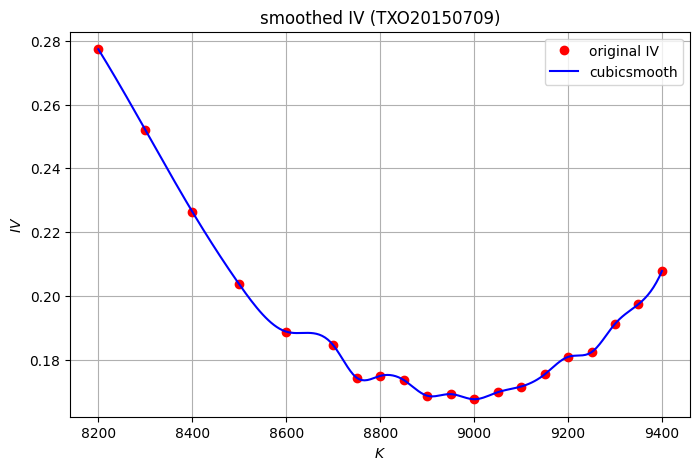

密度積分總和 ≈ 0.7661
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


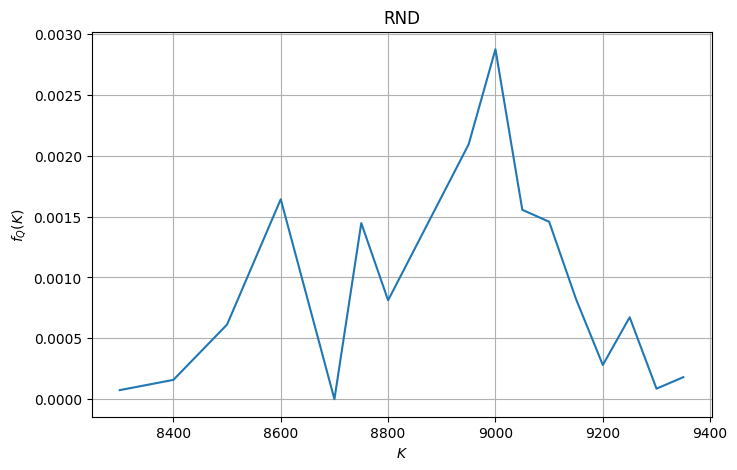

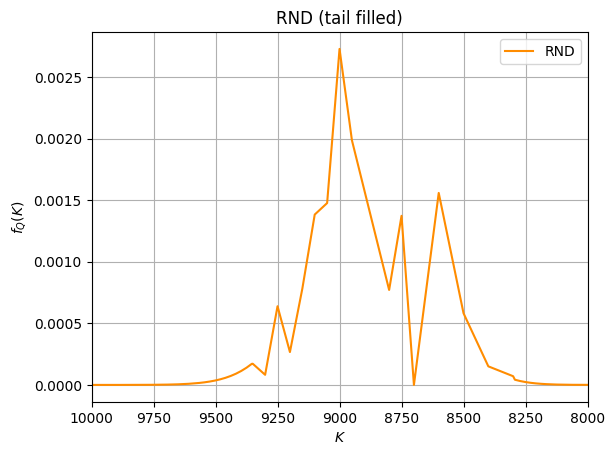

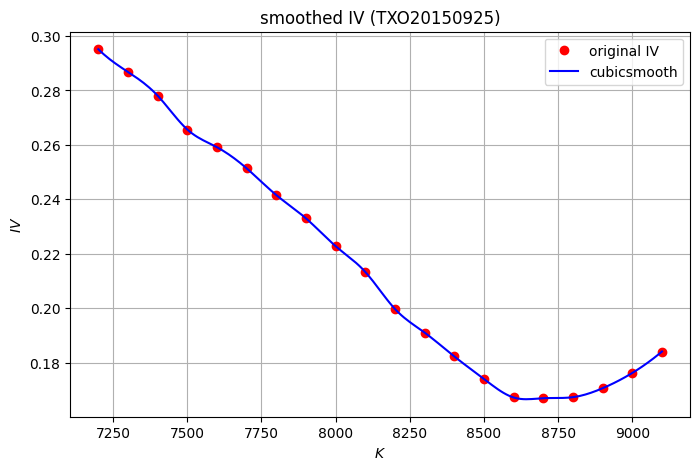

密度積分總和 ≈ 0.9269
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


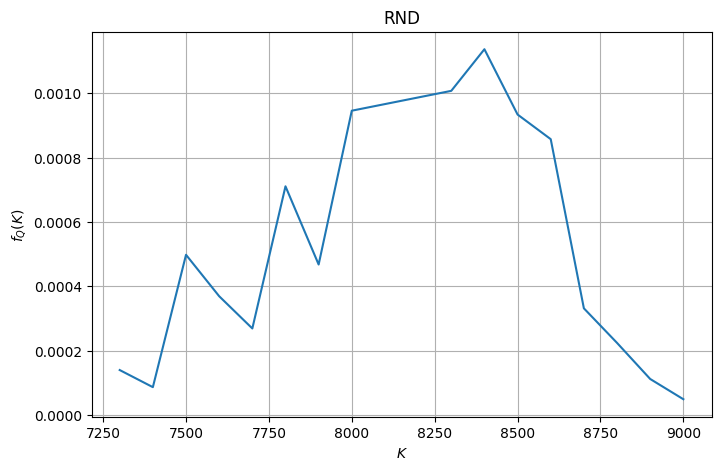

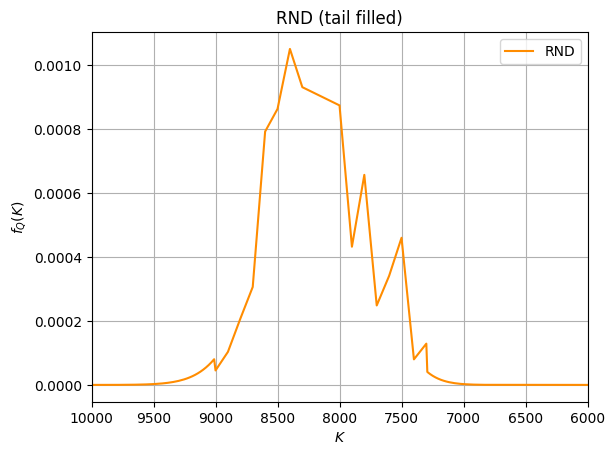

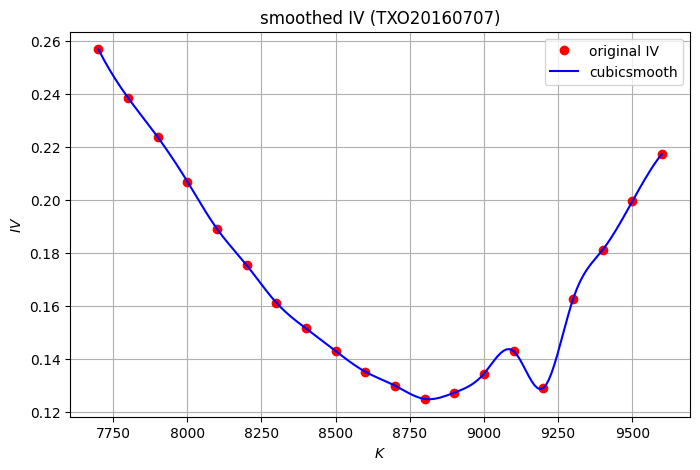

密度積分總和 ≈ 0.9165
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


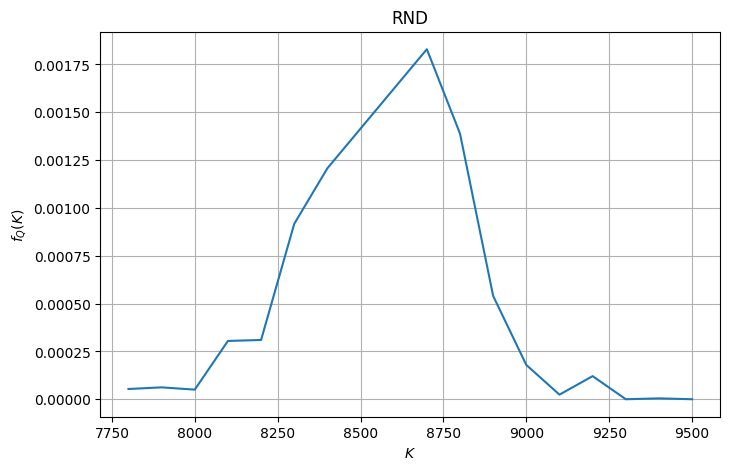

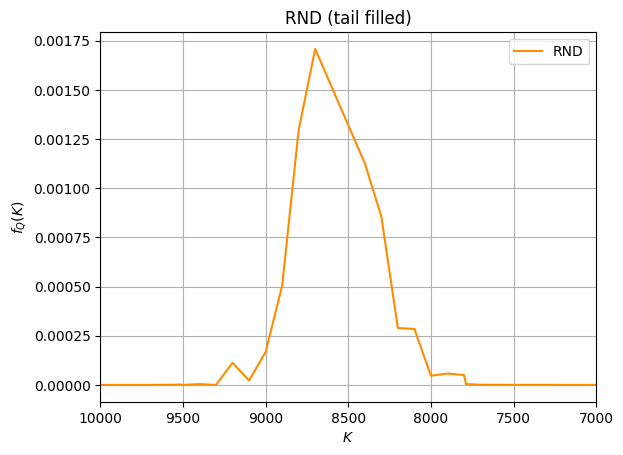

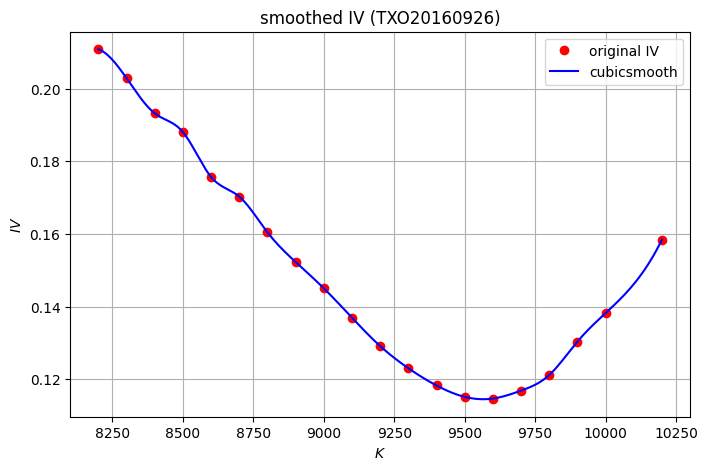

密度積分總和 ≈ 0.8383
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


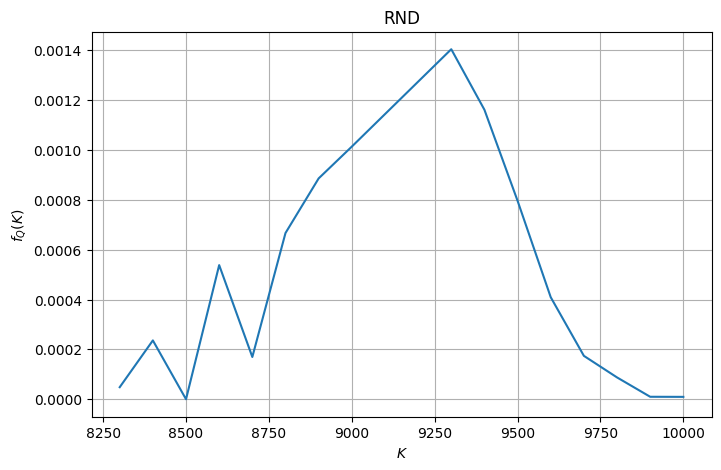

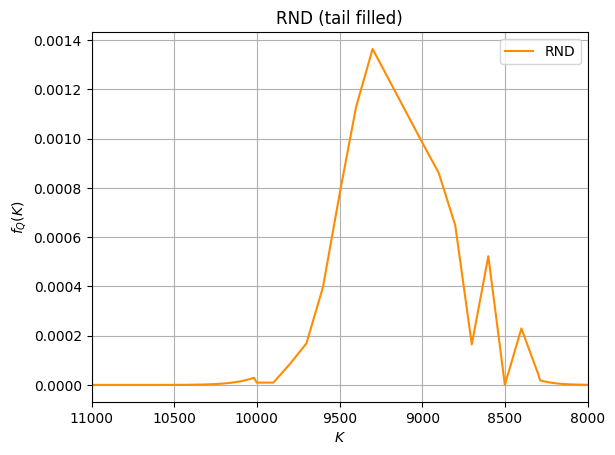

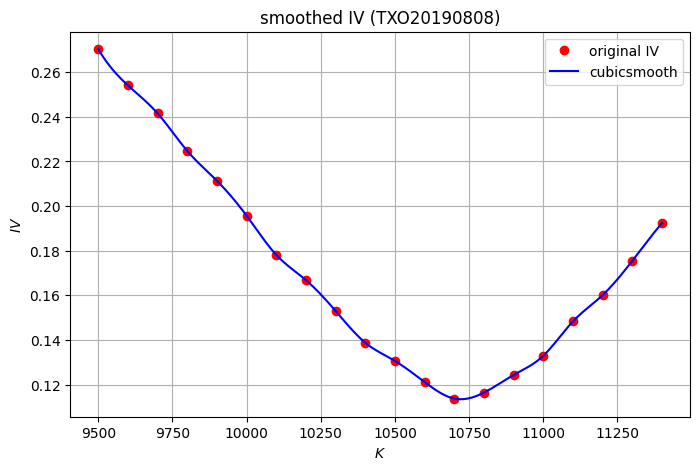

密度積分總和 ≈ 0.9174
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


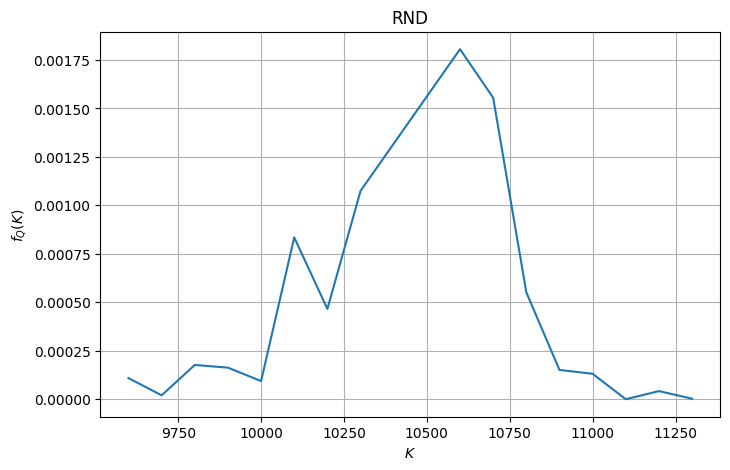

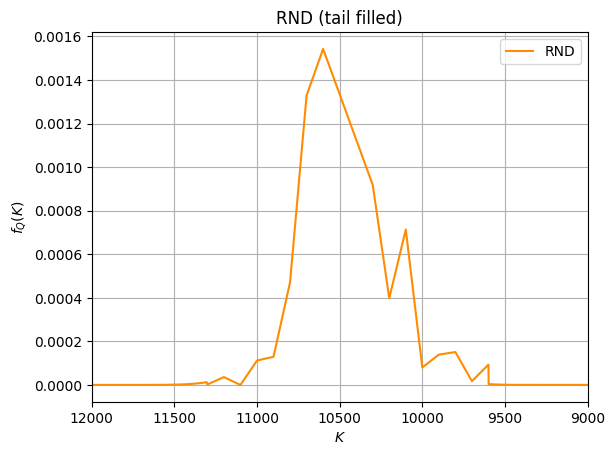

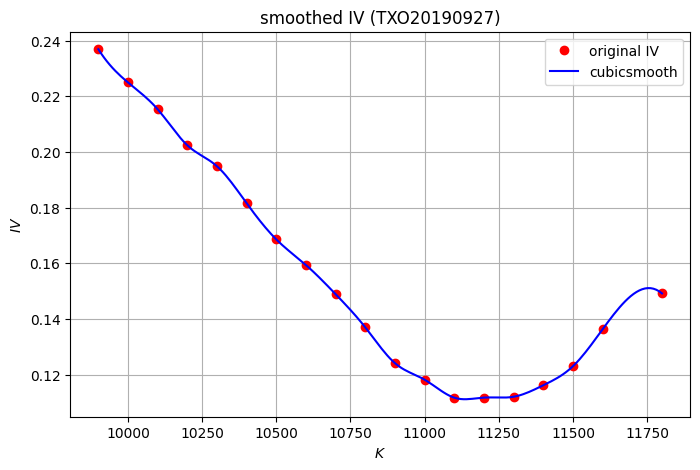

密度積分總和 ≈ 0.7698
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


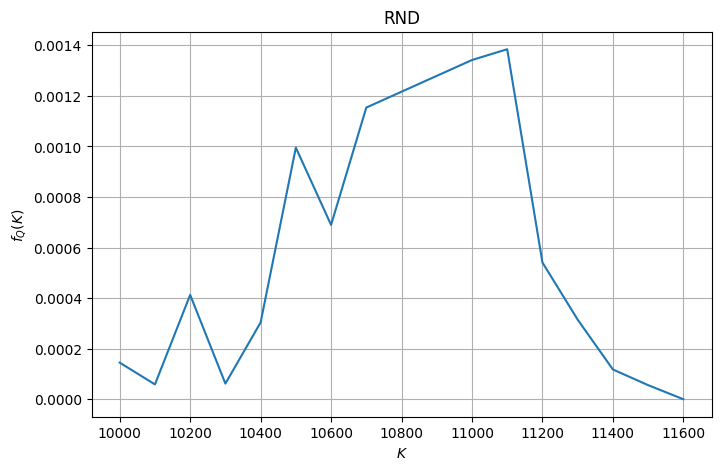

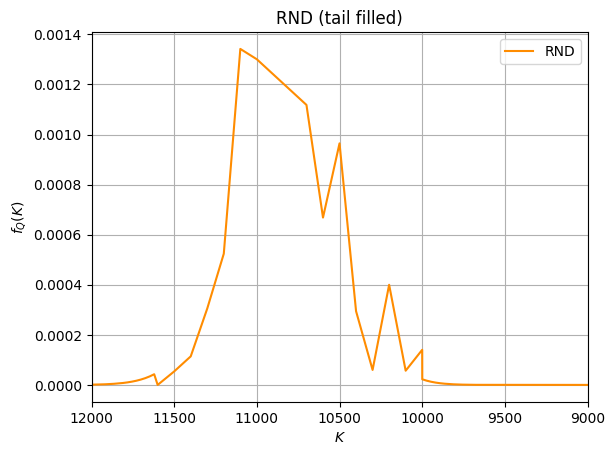

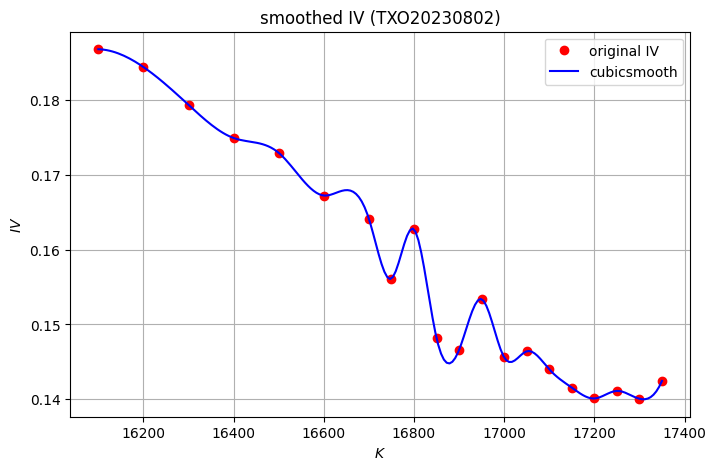

密度積分總和 ≈ 1.6008
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


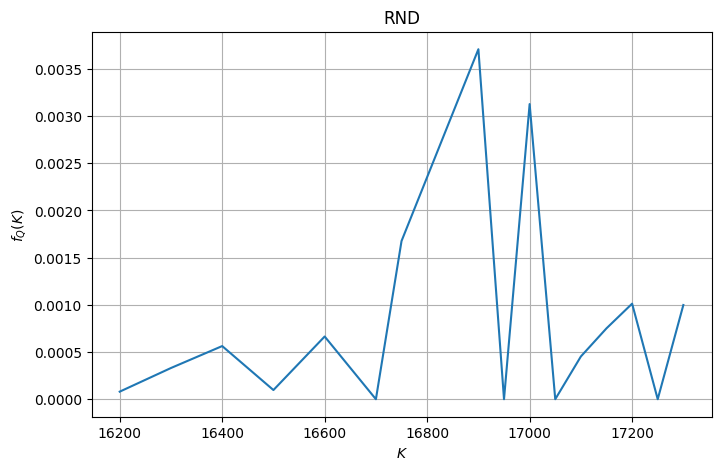

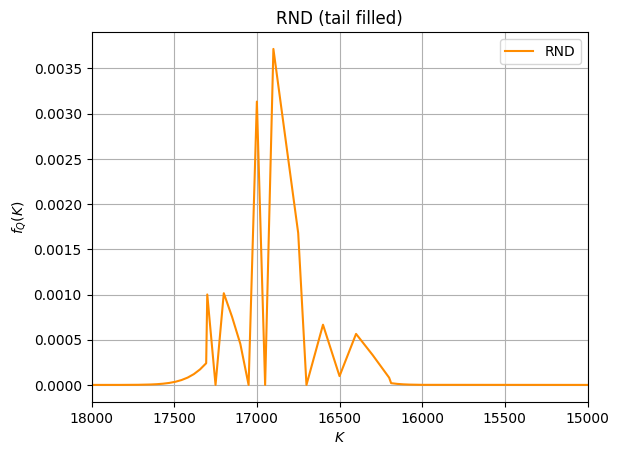

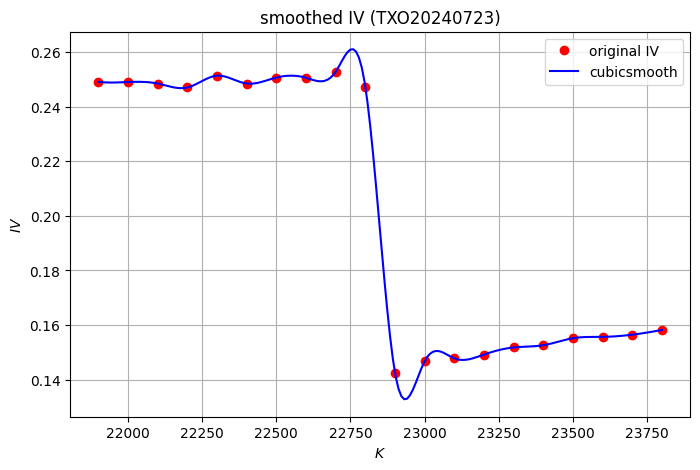

密度積分總和 ≈ 0.6557
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


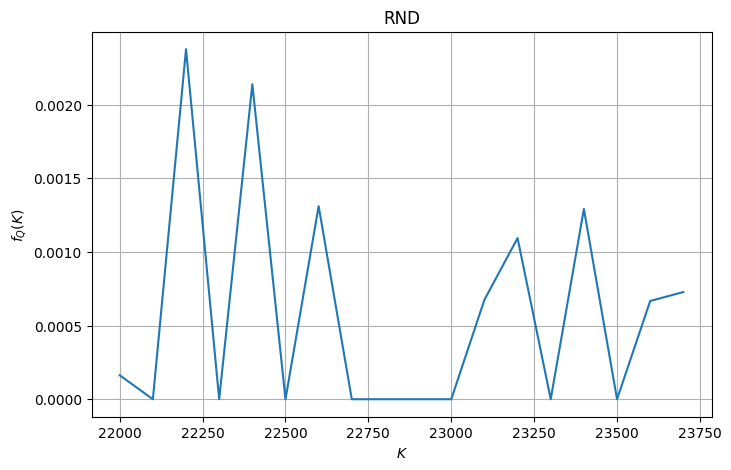

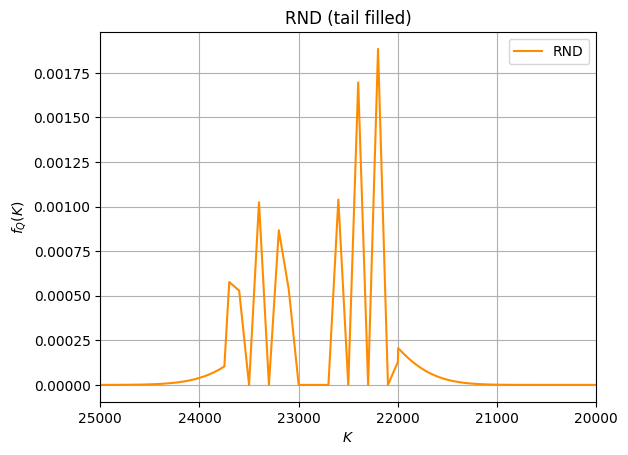

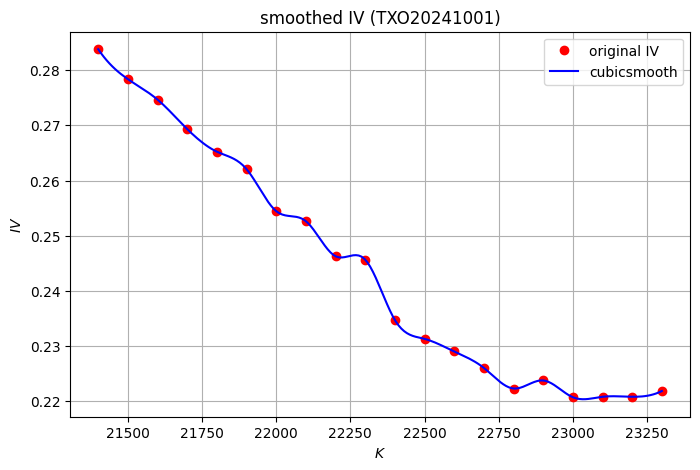

密度積分總和 ≈ 0.9249
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


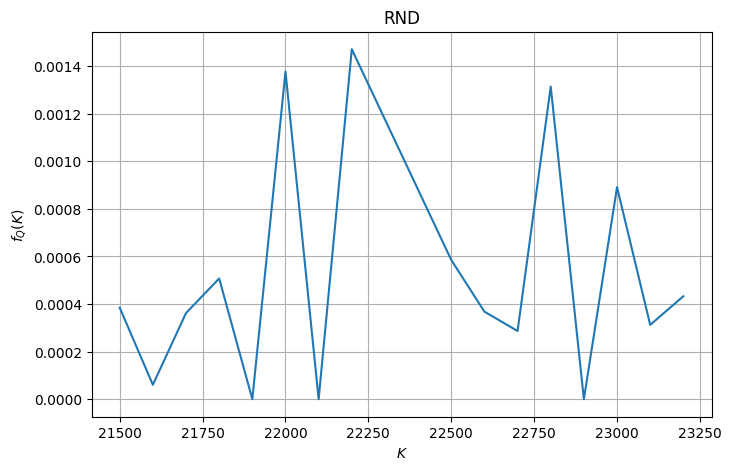

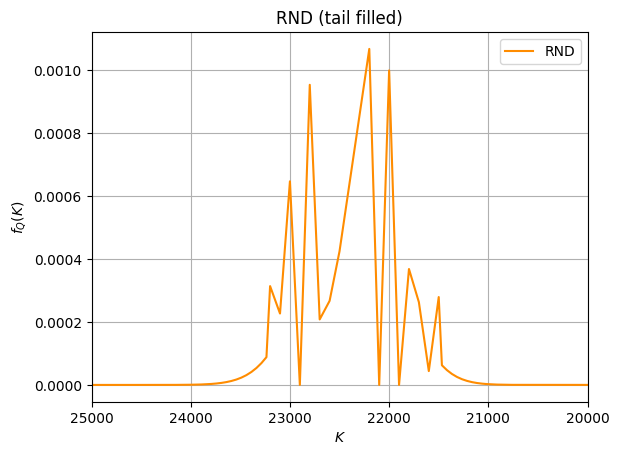

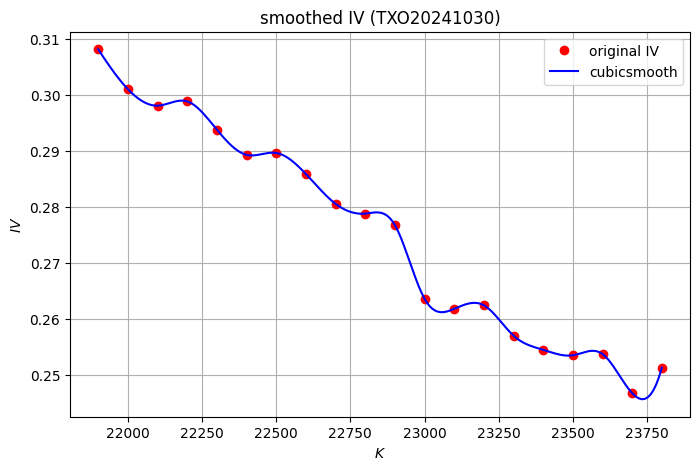

密度積分總和 ≈ 0.9150
修正後密度積分 ≈ 1.0000


<ipython-input-41-eeb203aa6a47>:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_vals /= np.trapz(f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean = np.trapz(K_vals * f_vals, K_vals)
<ipython-input-41-eeb203aa6a47>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var  = np.trapz((K_vals - mean)**2 * f_vals, K_vals)


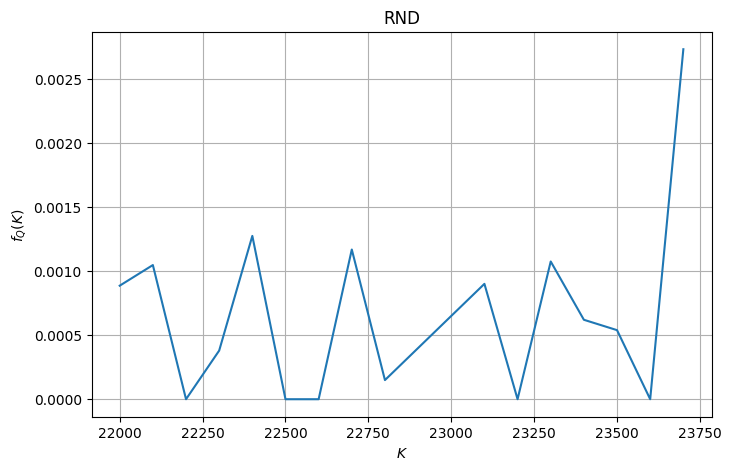

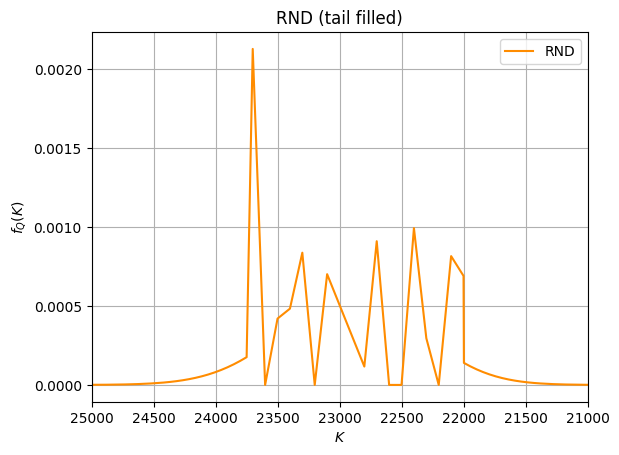

In [ ]:
# 2015-07-09
obj_20150709 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20150709.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20150709",
                S = 8875,
                r = 0.0076989,
                T = 4 / 252,
                xlim_lb=8000,
                xlim_ub=10000)
rnd_20150709, rndft_20150709 = obj_20150709.main_oper()

# 2015-09-25
obj_20150925 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20150925.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20150925",
                S = 8119,
                r = 0.0069622,
                T = 17 / 252,
                xlim_lb=6000,
                xlim_ub=10000)
rnd_20150925, rndft_20150925 = obj_20150925.main_oper()

#2016-07-07
obj_20160707 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20160707.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20160707",
                S = 8561,
                r = 0.0052978,
                T = 9 / 252,
                xlim_lb = 7000,
                xlim_ub = 10000)
rnd_20160707, rndft_20160707 = obj_20160707.main_oper()

# 20190926
obj_20160926 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20160926.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20160926",
                S = 9152,
                r = 0.0053011,
                T = 16 / 252,
                xlim_lb = 8000,
                xlim_ub = 11000)
rnd_20160926, rndft_20160926 = obj_20160926.main_oper()

# 2019-08-08
obj_20190808 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20190808.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20190808",
                S = 10436,
                r = 0.0054533,
                T = 9 / 252,
                xlim_lb = 9000,
                xlim_ub = 12000)
rnd_20190808, rndft_20190808 = obj_20190808.main_oper()

# 2019-09-27
obj_20190927 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20190927.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20190927",
                S = 10823,
                r = 0.0054578,
                T = 11 / 252,
                xlim_lb = 9000,
                xlim_ub = 12000)
rnd_20190927, rndft_20190927 = obj_20190927.main_oper()

#2023-08-02
obj_20230802 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20230802.csv',encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20230802",
                S = 16820,
                r = 0.0138,
                T = 10 / 252,
                xlim_lb = 15000,
                xlim_ub = 18000)
rnd_20230802, rndft_20230802 = obj_20230802.main_oper()

# 2024-07-23
obj_20240723 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20240723.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20240723",
                S = 22835,
                r = 0.153678,
                T = 21/252,
                xlim_lb = 20000,
                xlim_ub = 25000)
rnd_20240723, rndft_20240723 = obj_20240723.main_oper()


# 2024-10-01
obj_20241001 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20241001.csv', encoding = "Big5"),
                plot_name = "/content/drive/MyDrive/TXO20241001",
                S = 22391,
                r = 0.0157856,
                T = 9/252,
                xlim_lb = 20000,
                xlim_ub = 25000)
rnd_20241001, rndft_20241001 = obj_20241001.main_oper()

# 2024-10-30
obj_20241030 = OptionAnalysis(df = pd.read_csv('/content/drive/MyDrive/TXO_20241030.csv'),
                plot_name = "/content/drive/MyDrive/TXO20241030",
                S = 22901,
                r = 0.0158933,
                T = 14/252,
                xlim_lb = 21000,
                xlim_ub = 25000)
rnd_20241030, rndft_20241030 = obj_20241030.main_oper()

# 測度轉換

In [ ]:
df_HR30 = pd.read_csv('/content/drive/MyDrive/HR30.csv')

#### 報酬空間轉換:
$$x = \ln(\frac{K}{S})$$
#### 風險中立密度正規化:
$$f_Q(x)\leftarrow\frac{f_Q(x)}{\int f_Q(x)dx}$$
#### 歷史密度估計
$$\hat{g}(x)=KDE(x|HR)$$
#### 測度轉換
$$ L(x):=\frac{\widetilde g (x)}{f_Q(x)}$$
#### 轉換: 真實世界機率測度
$$f_P(x)=f_Q(x)\cdot L(x)$$
#### 真實世界機率測度轉換正規化:
$$f_P\leftarrow\frac{f_P(x)}{\int f_P(x)dx}$$
#### 文獻:
1. 正規化: Jackwerth (2000) Recovering Risk Aversion from Option Prices and Realized Returns

In [ ]:
def change_of_measure_rnd(rnd: pd.DataFrame, historical_returns, S, xlim_lb, xlim_ub, plot=True):
    """
    目的: 使用歷史 log-return 對風險中性密度進行機率測度轉換，建立實際密度估計。

    參數：
    - rnd_full: 包含 '履約價' 與 'RND' 的 DataFrame（未必有 x 軸）
    - historical_returns: 近30日 log-return 序列（Series 或 1D array）
    - S: 標的前日價格（用來將履約價轉換成 log-return）
    - plot: 是否繪圖顯示（預設 True）

    回傳：
    - result: DataFrame，包含 'x', 'RND', 'hist_density', 'P_density'
    - area_p: 測度轉換後 P 密度積分（應 ≈ 1）
    """

    # 轉換為報酬空間（log-return）
    K_vals = rnd["履約價"].values
    x_vals = np.log(K_vals / S)
    f_q = rnd["RND"].values

    # 確保排序一致（數值穩定）
    sort_idx = np.argsort(x_vals)
    x_vals = x_vals[sort_idx]
    f_q = f_q[sort_idx]

    # KDE 評估歷史密度（可調整 bw）
    kde = gaussian_kde(historical_returns, bw_method=0.1)
    g_hat = kde(x_vals)

    # 計算 likelihood ratio
    epsilon = 1e-8
    likelihood_ratio = g_hat / (f_q + epsilon)
    area_q = simpson(f_q, x_vals)
    f_q /= area_q
    f_p = f_q * likelihood_ratio

    # 正規化
    area_p = simpson(f_p, x_vals)
    if area_p > 1e-8: f_p /= area_p
    else: f_p[:] = 0

    area_g = simpson(g_hat, x_vals)
    if area_g > 1e-8: g_hat /= area_g
    else: g_hat[:] = 0


    # 整理輸出
    result = pd.DataFrame({
        'x': x_vals,
        'RND': f_q,
        'hist_density': g_hat,
        'likelihood_ratio': likelihood_ratio,
        'P_density': f_p
    })
    # 畫圖
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(x_vals, f_q / f_q.sum(), label='Risk-Neutral Density (Q)', color='blue')
        plt.plot(x_vals, g_hat / g_hat.sum(), label='Historical KDE (P, raw)', color='gray')
        plt.plot(x_vals, f_p / f_p.sum(), label='Adjusted P Density', color='green', linestyle='--')
        plt.legend()
        plt.title("Measure Change: From Q to P")
        plt.xlabel("Log-Return (x = log(K/S))")
        plt.xlim(xlim_lb, xlim_ub)
        plt.ylabel("Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return result

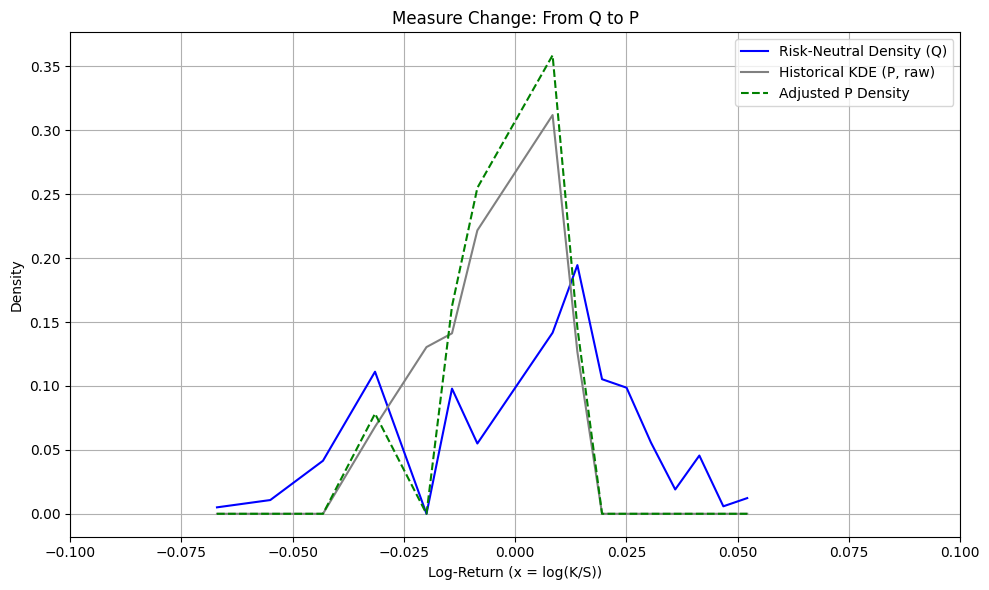

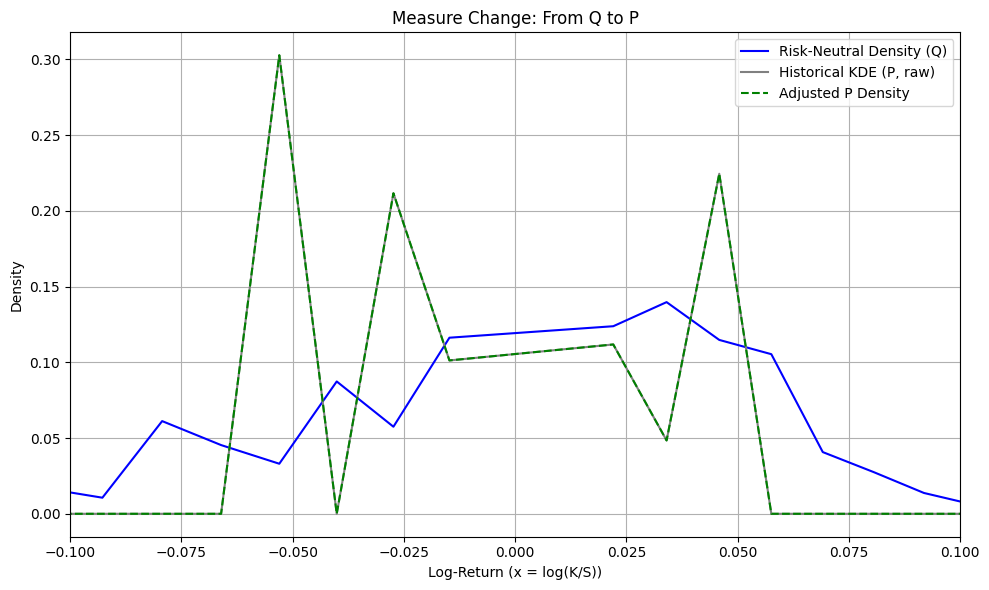

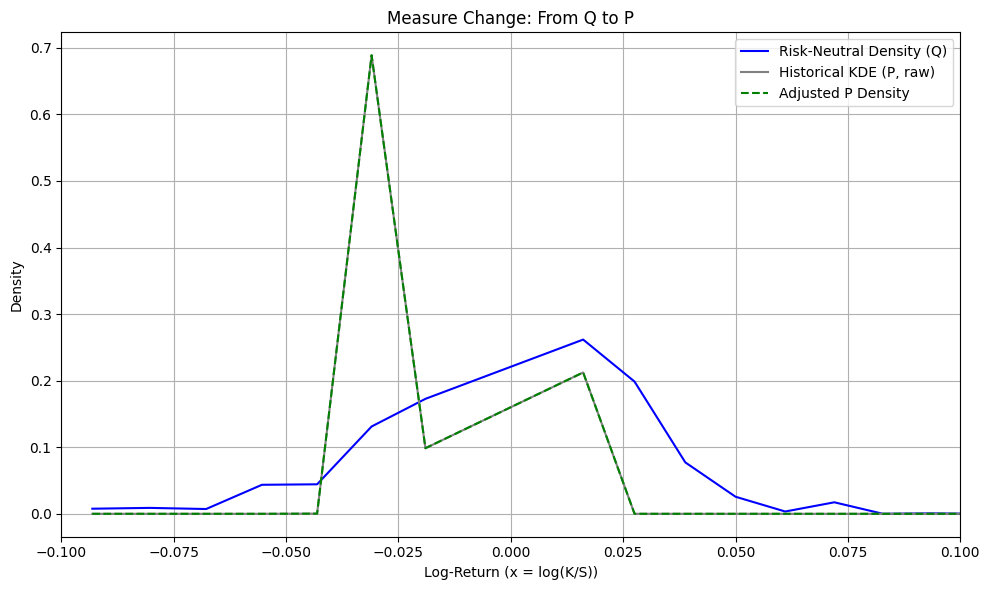

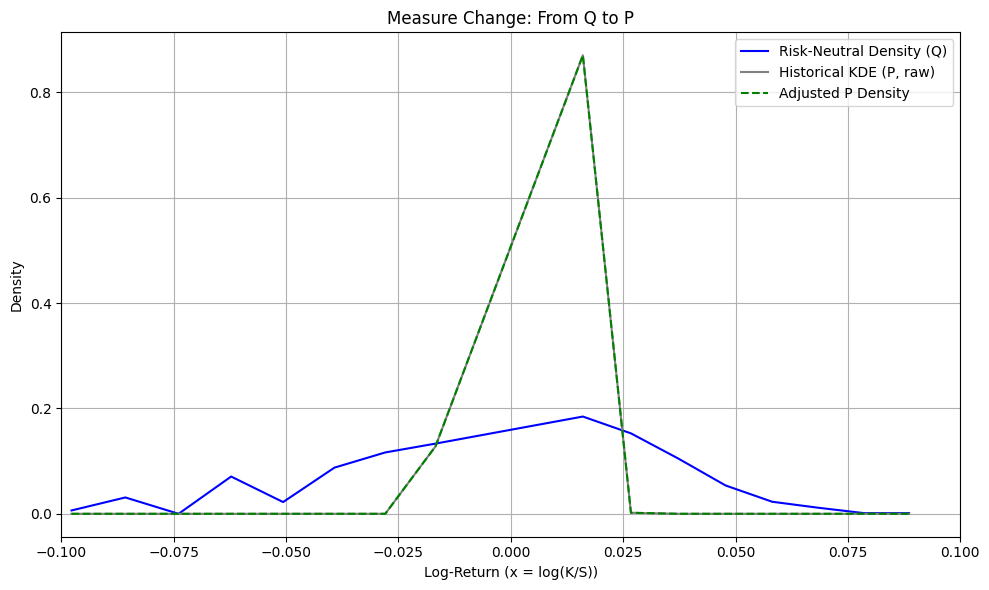

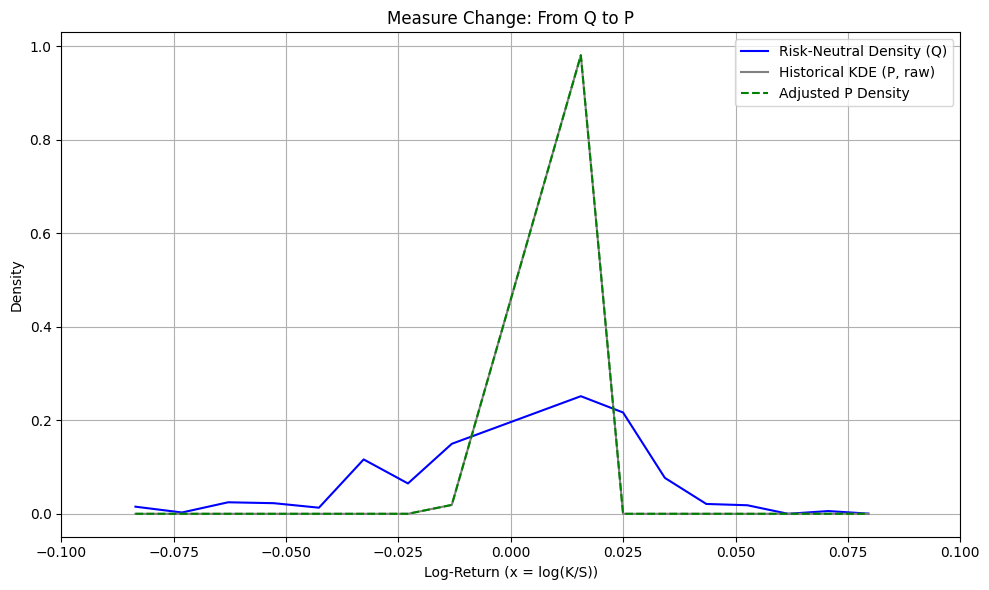

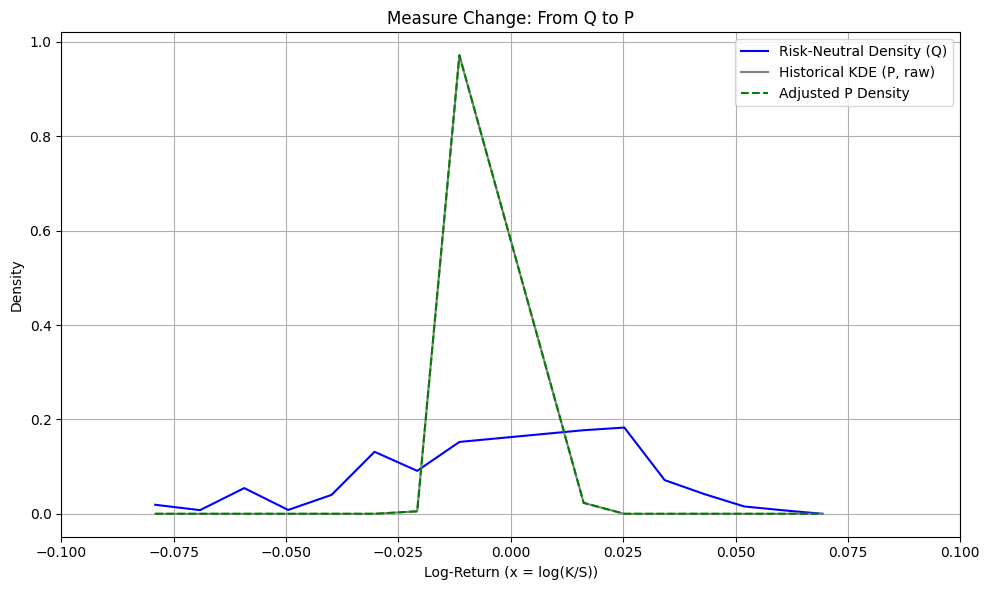

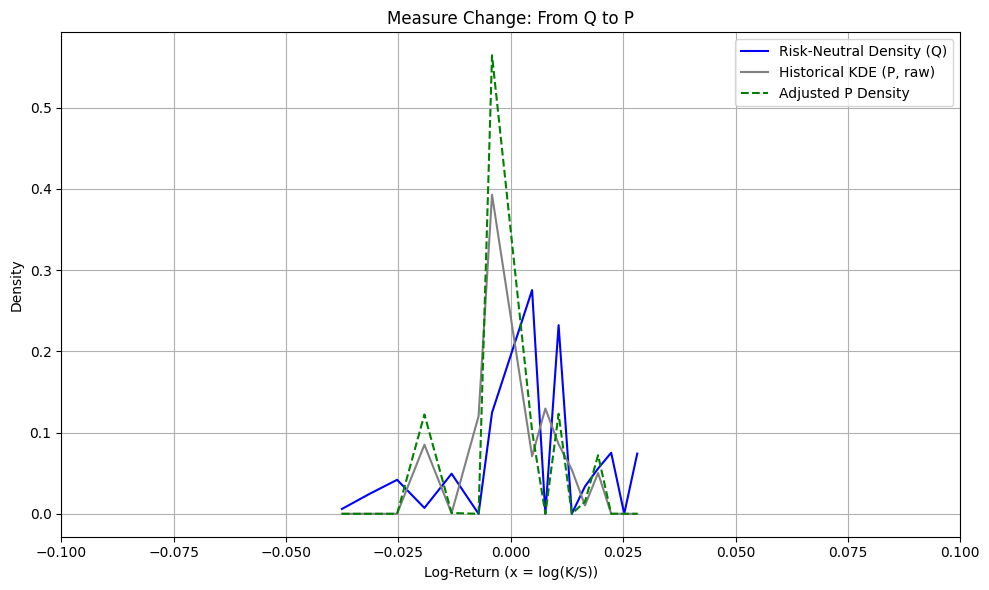

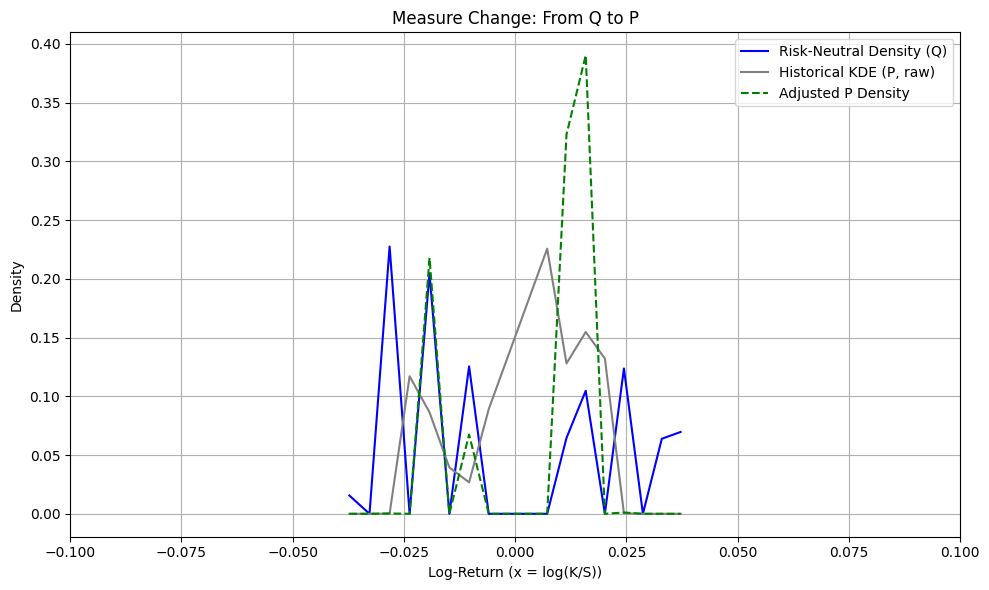

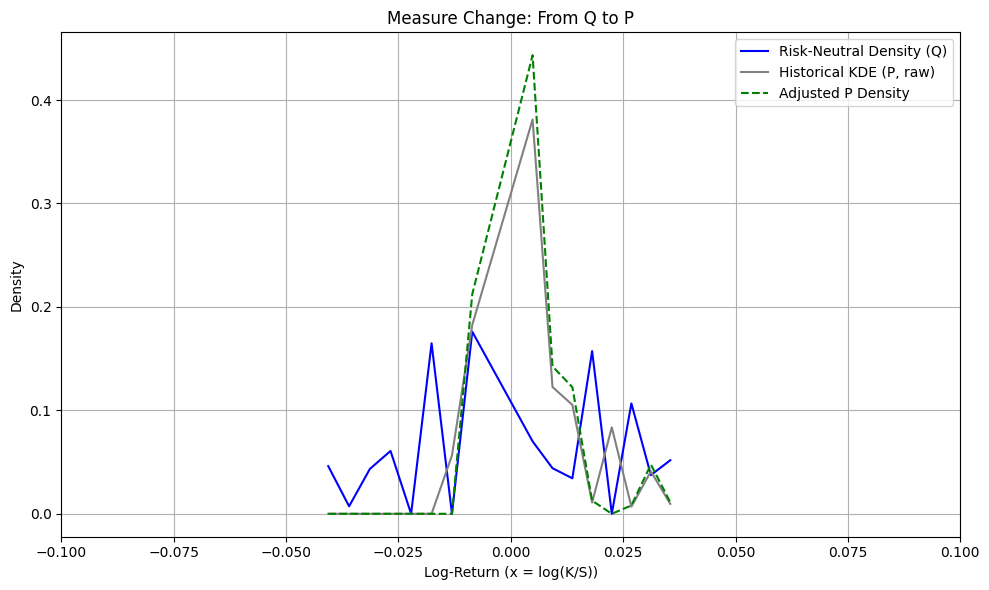

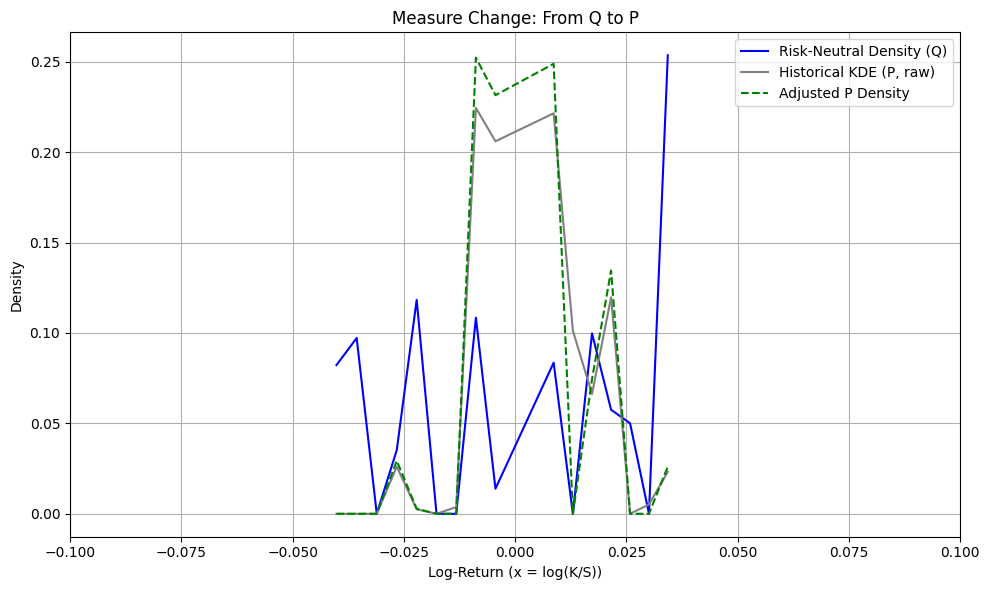

In [ ]:
result_20150709 = change_of_measure_rnd(rnd_20150709, df_HR30["2015/7/9"].values.flatten(), S=obj_20150709.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20150925 = change_of_measure_rnd(rnd_20150925, df_HR30["2015/9/25"].values.flatten(), S=obj_20150925.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20160707 = change_of_measure_rnd(rnd_20160707, df_HR30["2016/7/7"].values.flatten(), S=obj_20160707.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20160926 = change_of_measure_rnd(rnd_20160926, df_HR30["2016/9/26"].values.flatten(), S=obj_20160926.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20190808 = change_of_measure_rnd(rnd_20190808, df_HR30["2019/8/8"].values.flatten(), S=obj_20190808.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20190927 = change_of_measure_rnd(rnd_20190927, df_HR30["2019/9/27"].values.flatten(), S=obj_20190927.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20230802 = change_of_measure_rnd(rnd_20230802, df_HR30["2023/8/2"].values.flatten(), S=obj_20230802.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20240723 = change_of_measure_rnd(rnd_20240723, df_HR30["2024/7/23"].values.flatten(), S=obj_20240723.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20241001 = change_of_measure_rnd(rnd_20241001, df_HR30["2024/10/1"].values.flatten(), S=obj_20241001.S, xlim_lb = -0.1, xlim_ub = 0.1)
result_20241030 = change_of_measure_rnd(rnd_20241030, df_HR30["2024/10/30"].values.flatten(), S=obj_20241030.S, xlim_lb = -0.1, xlim_ub = 0.1)
f = [
    result_20150709,
    result_20150925,
    result_20160707,
    result_20160926,
    result_20190808,
    result_20190927,
    result_20230802,
    result_20240723,
    result_20241001,
    result_20241030
]

## 引入資料: 避險成分價格資料

In [ ]:
hedge_portfolio_price_data = pd.read_csv('/content/drive/MyDrive/hedge_portfolio_price_data.csv')

# 整理index
hedge_portfolio_price_data["Date"] = pd.to_datetime(hedge_portfolio_price_data["Date"], errors="coerce")
hedge_portfolio_price_data["Date"] = hedge_portfolio_price_data["Date"].dt.strftime("%Y-%m-%d")
hedge_portfolio_price_data = hedge_portfolio_price_data.set_index("Date")
symbols = list(hedge_portfolio_price_data.columns)

#hedge_portfolio_price_data

## 引入資料: 休市起始、結束日；前一、後一交易日

In [ ]:
DateIndex = pd.read_csv("/content/drive/MyDrive/DateIndex.csv")

DateIndex

,休市起始日,休市結束日,前一交易日,後一交易日
0,2015-07-10,2015-07-10,2015-07-09,2015-07-13
1,2015-09-28,2015-09-29,2015-09-25,2015-09-30
2,2016-07-08,2016-07-08,2016-07-07,2016-07-11
3,2016-09-27,2016-09-28,2016-09-26,2016-09-29
4,2019-08-09,2019-08-09,2019-08-08,2019-08-12
5,2019-09-30,2019-09-30,2019-09-27,2019-10-01
6,2023-08-03,2023-08-03,2023-08-02,2023-08-04
7,2024-07-24,2024-07-25,2024-07-23,2024-07-26
8,2024-10-02,2024-10-03,2024-10-01,2024-10-04
9,2024-10-31,2024-10-31,2024-10-30,2024-11-01


## 資料處理: 計算台股颱風休市日對應外部市場的$\mathrm r$

In [ ]:
r_df_list = [] # 初始化報酬率列表

for idx, row in DateIndex.iterrows(): # 對每筆停市事件計算所有指數期貨的 log return
    pre_date = row["前一交易日"]
    post_date = row["後一交易日"]
    try:
        pre_prices = hedge_portfolio_price_data.loc[pre_date]
        post_prices = hedge_portfolio_price_data.loc[post_date]
        log_returns = np.log(post_prices / pre_prices)
        r_df_list.append(log_returns)
    except KeyError: # 若有日期缺資料則略過
        print(f"缺資料: {pre_date} 或 {post_date}")
        r_df_list.append(pd.Series([np.nan]*len(symbols), index=symbols))

# 整合成 DataFrame，對齊 r_T_df
r_hedge_df = pd.DataFrame(r_df_list)
r_hedge_df["休市起始日"] = DateIndex["休市起始日"].values
r_hedge_df.set_index("休市起始日", inplace=True) # 最終：每筆颱風事件 + 避險資產報酬

#r_hedge_df

# Monte Carlo Simulation

$$\mathbf{R}^{(\mathrm{cond})} = \text{Asset return data under specific market conditions}$$
$$
\boldsymbol{\mu}^{(\mathrm{cond})} = \mathbb{E} \left[ \mathbf{R}^{(\mathrm{cond})} \right] \quad \text{(Conditional mean vector)}
$$
$$\Sigma^{(\mathrm{cond})} = \mathrm{Cov} \left( \mathbf{R}^{(\mathrm{cond})} \right) \quad \text{(Conditional covariance matrix)}$$

$$
\mathbf{r}^{(k)} \sim \mathcal{N}\left(\boldsymbol{\mu}^{(\mathrm{cond})}, \Sigma^{(\mathrm{cond})}\right), \quad k = 1, 2, \ldots, K
$$

$$\text{where each } \mathbf{r}^{(k)} \in \mathbb{R}^N \text{ represents one simulated return vector of the hedging portfolio components.}$$


In [ ]:
def monte_carlo_single_day(returns_df, n_simulations=10000, seed = 42):
    """
    目的: 模擬避險投資組合成分報酬率
    """
    if seed is not None: np.random.seed(seed)

    mu = returns_df.mean().values             # 平均報酬率 (n_assets,)
    cov = returns_df.cov().values             # 共變異數矩陣 (n_assets, n_assets)

    simulated_returns = np.random.multivariate_normal(mu, cov, size=n_simulations) # 使用多變量常態分布直接模擬 n_simulations 筆單日報酬
    simulated_df = pd.DataFrame(simulated_returns, columns=returns_df.columns) # 轉成 DataFrame，欄位名稱與原始資料相同

    return simulated_df

$$
\text{Given } m \text{ risk-neutral densities } \left\{ f_Q^{(1)}(x), f_Q^{(2)}(x), \ldots, f_Q^{(m)}(x) \right\}$$

$$\text{For each } i = 1, 2, \ldots, n:$$

$$
\quad \text{1. Randomly select } j_i \sim \text{UniformDiscrete}(\{1, 2, \ldots, m\})
$$

$$
\quad \text{2. Sample } r_i \sim f_Q^{(j_i)}(x)
$$

$$
\text{The simulated return set is } \{ r_1, r_2, \ldots, r_n \}
$$


$$
\text{Given } m \text{ risk-neutral densities } \left\{ f_P^{(1)}(x), f_P^{(2)}(x), \ldots, f_P^{(m)}(x) \right\}$$

$$\text{For each } i = 1, 2, \ldots, n:$$

$$
\quad \text{1. Randomly select } j_i \sim \text{UniformDiscrete}(\{1, 2, \ldots, m\})
$$

$$
\quad \text{2. Sample } r_i \sim f_P^{(j_i)}(x)
$$

$$
\text{The simulated return set is } \{ r_1, r_2, \ldots, r_n \}
$$


In [ ]:
def MC_sim_batch_vectorized(f = f, method = 'Q', n = 10000, seed = 42):
    """
    目的: 模擬被避險資產報酬率，給定機率測度
    參數:
      f: 機率測度集合
      method: 'Q'-風險中立機率測度； 'P'-真實世界機率測度
      n: 模擬資料筆數
    回傳值: 模擬資料 (np.array)
    """
    if seed is not None: np.random.seed(seed)

    temp = random.choice(f)
    if method.upper() == 'Q': density = temp['RND'].values
    elif method.upper() == 'P': density = temp['P_density'].values
    else: raise ValueError("method 必須為 'Q' 或 'P'")

    x_vals = temp['x'].values
    density = np.clip(density, 0, None)
    density /= np.trapz(density, x_vals)

    cdf = np.cumsum(density)
    cdf /= cdf[-1]

    inv_cdf = lambda u: np.interp(u, cdf, x_vals)

    u = np.random.uniform(0, 1, n)
    sim_returns = inv_cdf(u)

    return sim_returns

In [ ]:
simulated_r_hedge = monte_carlo_single_day(r_hedge_df, n_simulations=10000, seed=20) #避險投資組合模擬報酬率 (n = 10000)
simulated_r_T_Q = MC_sim_batch_vectorized(f, method='Q', n=10000) #被避險資產模擬報酬率 (n = 10000)]
simulated_r_T_P = MC_sim_batch_vectorized(f, method='P', n=10000) #被避險資產模擬報酬率 (n = 10000)]

<ipython-input-56-a90d7c47b8cf>:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  density /= np.trapz(density, x_vals)


# 最佳化問題:
$$\min_{\mathbf{w} \in \mathbb{R}^N} \quad \frac{1}{K} \sum_{k=1}^K \left( \mathbf{r}_{k, t}^\top \mathbf{w} - \hat{r}_{k, t}^{(T)} \right)^2$$
$$\text{s.t.}$$
$$\sum_{i=1}^N w_i \leq 1,$$
$$\sum_{i=1}^N |w_i| \leq 2.$$

In [ ]:
def Opt_problem_solver (simulated_r_hedge = simulated_r_hedge, simulated_r_T = simulated_r_T_Q):
  asset_names = simulated_r_hedge.columns
  r = simulated_r_hedge.values
  r_T = simulated_r_T
  T, N = r.shape

  w = cp.Variable(N)  # 建立最佳化變數: 資產權重變數

  # 計算所有樣本的 tracking error：每一筆模擬下的組合報酬 - 目標資產報酬
  tracking_errors = r @ w - r_T

  # 目標：最小化平均平方追蹤誤差
  objective = cp.Minimize(cp.sum_squares(tracking_errors) / T)

  # 限制條件：
  constraints = []

  constraints.append(cp.sum(w) <= 1) # 避險投組總權重 ≤ 1（可留現金）

  constraints.append(cp.norm1(w) <= 2) # 控制總權重絕對值 ≤ 2（避免過度槓桿或極端部位）

  # 可以加入非負限制（長倉 only），視需求而定
  # constraints.append(w >= 0)

  # 定義並求解最佳化問題
  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.SCS)

  optimal_weights = pd.Series(w.value, index=asset_names)

  mse = problem.value
  std = np.sqrt(mse)

  significant_weights = optimal_weights[optimal_weights.abs() > 1e-4]

  print("最佳化組合權重（按高到低排序）:")
  print(optimal_weights.sort_values(ascending=False))
  print(f"\n最壞情境下的平均平方追蹤誤差(MSE): {mse:.8f}")
  print(f"最壞情境下的追蹤誤差標準差上限 (sqrt MSE): {std:.8f}")
  print("\n權重絕對值大於 0.0001 的標的（實際投資部位）:")
  print(significant_weights.sort_values(ascending=False))

  return mse, optimal_weights

In [ ]:
mse_Q, optimal_weights_Q = Opt_problem_solver(simulated_r_T = simulated_r_T_Q)

最佳化組合權重（按高到低排序）:
ZSO1    0.814001
ZTY1    0.152741
ZSI1    0.112623
ZUL1   -0.017987
ZRP1   -0.261425
ZTW1   -0.275961
FMI1   -0.365263
dtype: float64

最壞情境下的平均平方追蹤誤差(MSE): 0.00098656
最壞情境下的追蹤誤差標準差上限 (sqrt MSE): 0.03140958

權重絕對值大於 0.0001 的標的（實際投資部位）:
ZSO1    0.814001
ZTY1    0.152741
ZSI1    0.112623
ZUL1   -0.017987
ZRP1   -0.261425
ZTW1   -0.275961
FMI1   -0.365263
dtype: float64


In [ ]:
mse_P, optimal_weights_P = Opt_problem_solver(simulated_r_T = simulated_r_T_P)

最佳化組合權重（按高到低排序）:
FMI1    0.268600
ZUL1    0.151183
ZRP1    0.130775
ZTW1    0.007007
ZSI1   -0.093626
ZTY1   -0.161165
ZSO1   -0.460067
dtype: float64

最壞情境下的平均平方追蹤誤差(MSE): 0.00021033
最壞情境下的追蹤誤差標準差上限 (sqrt MSE): 0.01450292

權重絕對值大於 0.0001 的標的（實際投資部位）:
FMI1    0.268600
ZUL1    0.151183
ZRP1    0.130775
ZTW1    0.007007
ZSI1   -0.093626
ZTY1   -0.161165
ZSO1   -0.460067
dtype: float64


# TEV

In [ ]:
TEV_data = pd.read_csv("/content/drive/MyDrive/TEV_cal_data.csv")
TEV_data = TEV_data.dropna()
TEV_data["real_r_T"] = np.log(TEV_data["underlying_asset_rare"] / TEV_data["underlying_asset_fore"]) # 計算真實報酬

TEV_data

,index,start,end,t-1,t+1,underlying_asset_fore,underlying_asset_rare,real_r_T
0,0.0,2015/7/10,2015/7/10,2015/7/9,2015/7/13,8875.0,8993.0,0.013208
1,1.0,2015/9/28,2015/9/29,2015/9/25,2015/9/30,8119.0,8135.0,0.001969
2,2.0,2016/7/8,2016/7/8,2016/7/7,2016/7/11,8561.0,8734.0,0.020006
3,3.0,2016/9/27,2016/9/28,2016/9/26,2016/9/29,9152.0,9251.0,0.010759
4,4.0,2019/8/9,2019/8/9,2019/8/8,2019/8/12,10436.0,10439.0,0.000287
5,5.0,2019/9/30,2019/9/30,2019/9/27,2019/10/1,10823.0,10953.0,0.011940
6,6.0,2023/8/3,2023/8/3,2023/8/2,2023/8/4,16820.0,16823.0,0.000178
7,7.0,2024/7/24,2024/7/25,2024/7/23,2024/7/26,22835.0,22096.0,-0.032898
8,8.0,2024/10/2,2024/10/3,2024/10/1,2024/10/4,22391.0,22288.0,-0.004611
9,9.0,2024/10/31,2024/10/31,2024/10/30,2024/11/1,22901.0,22767.0,-0.005868


#### 追蹤誤差（Tracking Error）:
$$e_t=\mathbf r^{\top}_t-r_{\text{T},t}$$

#### 追蹤誤差變異數 (TEV)：
$$\text{TEV}=\frac{1}{T-1}\sum^T_{t=1}(e_t-\overline{e})^2$$
$$\text{where }\overline{e}=\frac{1}{T}\sum^T_{t=1}e_t$$
#### 追蹤誤差標準差：
$$\text{TE}_\text{std}=\sqrt{\text{TEV}}$$
#### 均方根誤差 (RMSE)：
$$\text{RMSE}=\sqrt{\frac{1}{T}\sum^T_{t=1}e_t^2}$$

In [ ]:
def calculate_tracking_error(r_hedge = r_hedge_df.values, w_star = optimal_weights_Q, real_r_T = TEV_data["real_r_T"].values):
  # 計算 tracking error
  tracking_error = r_hedge @ w_star - real_r_T  # shape: (T,)


  tev = np.var(tracking_error, ddof = 1)  # 計算 TEV（追蹤誤差變異數），使用 population variance（除以 T - 1）


  te_std = np.std(tracking_error) # 標準差
  rmse = np.sqrt(np.mean(tracking_error**2)) # RMSE


  print(f"Tracking Error Variance (TEV): {tev:.6f}")
  print(f"Tracking Error Std Dev: {te_std:.6f}")
  print(f"RMSE: {rmse:.6f}")

  return float(tev), float(rmse)

In [ ]:
tev_Q, rmse_Q = calculate_tracking_error(r_hedge = r_hedge_df.values, w_star = optimal_weights_Q, real_r_T = TEV_data["real_r_T"].values)

Tracking Error Variance (TEV): 0.000186
Tracking Error Std Dev: 0.012928
RMSE: 0.014570


In [ ]:
tev_P, rmse_P = calculate_tracking_error(r_hedge = r_hedge_df.values, w_star = optimal_weights_P, real_r_T = TEV_data["real_r_T"].values)

Tracking Error Variance (TEV): 0.000217
Tracking Error Std Dev: 0.013963
RMSE: 0.013968


# Further Discussion: CVaR

In [ ]:
def Opt_problem_CVaR_solver(simulated_r_hedge, simulated_r_T, alpha=0.95):
    asset_names = simulated_r_hedge.columns
    r = simulated_r_hedge.values
    r_T = simulated_r_T
    T, N = r.shape

    w = cp.Variable(N)
    eta = cp.Variable()               # VaR proxy
    z = cp.Variable(T)                # CVaR slack variables

    # 損失定義為絕對追蹤誤差
    tracking_errors = r @ w - r_T
    losses = cp.abs(tracking_errors)

    # CVaR objective
    objective = cp.Minimize(eta + (1 / ((1 - alpha) * T)) * cp.sum(z))

    constraints = [
        z >= losses - eta,
        z >= 0,
        cp.sum(w) <= 1,
        cp.norm1(w) <= 2,
        # w >= 0  # 如需長倉限制，啟用此行
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    optimal_weights = pd.Series(w.value, index=asset_names)
    significant_weights = optimal_weights[optimal_weights.abs() > 1e-4]

    print("CVaR 最佳化組合權重（按高到低排序）:")
    print(optimal_weights.sort_values(ascending=False))
    print(f"\nCVaR（α={alpha}）下的預期損失: {problem.value:.8f}")
    print("\n權重絕對值大於 0.0001 的標的:")
    print(significant_weights.sort_values(ascending=False))

    return problem.value, optimal_weights


In [ ]:
Opt_problem_CVaR_solver(simulated_r_hedge, simulated_r_T_Q, alpha=0.95)

CVaR 最佳化組合權重（按高到低排序）:
ZSO1    7.541424e-01
ZTY1    2.041450e-01
ZUL1    5.661416e-02
ZSI1    2.574276e-07
FMI1   -6.735213e-02
ZTW1   -4.049676e-01
ZRP1   -5.127795e-01
dtype: float64

CVaR（α=0.95）下的預期損失: 0.06798734

權重絕對值大於 0.0001 的標的:
ZSO1    0.754142
ZTY1    0.204145
ZUL1    0.056614
FMI1   -0.067352
ZTW1   -0.404968
ZRP1   -0.512779
dtype: float64


(np.float64(0.06798733504895399),
 ZRP1   -5.127795e-01
 FMI1   -6.735213e-02
 ZSO1    7.541424e-01
 ZTW1   -4.049676e-01
 ZUL1    5.661416e-02
 ZTY1    2.041450e-01
 ZSI1    2.574276e-07
 dtype: float64)